In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from skgarden import MondrianForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams

import pandas as pd

C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [18]:
network = pd.read_csv('C:/Users/HakkyuKim/Desktop/yeonwoo/challenge/intial_trainig_stage.csv', index_col='date', parse_dates=['date'])
network.head()

network2 = pd.read_csv('C:/Users/HakkyuKim/Desktop/yeonwoo/challenge/intial_trainig_stage.csv')
network2.head()

network.describe()

,target
count,172800.000000
mean,428.157720
std,39.253344
min,241.308025
25%,402.000000
50%,426.000000
75%,452.000000
max,677.615002


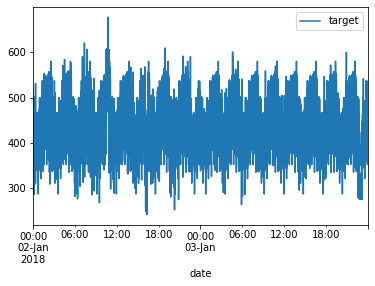

In [3]:
network.plot()

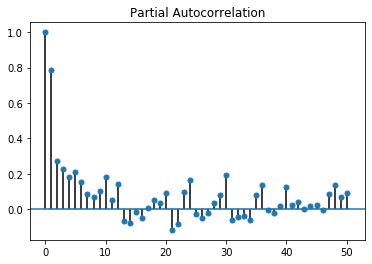

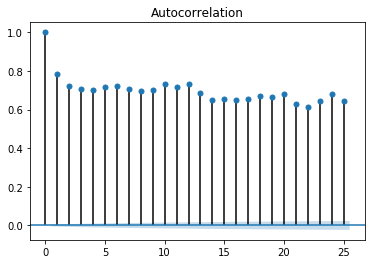

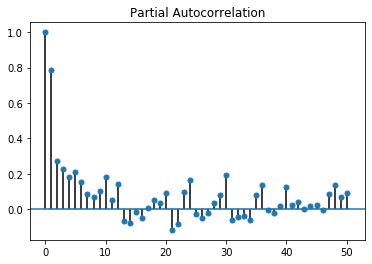

In [4]:
plot_acf(network, lags=25);
plot_pacf(network, lags=50)

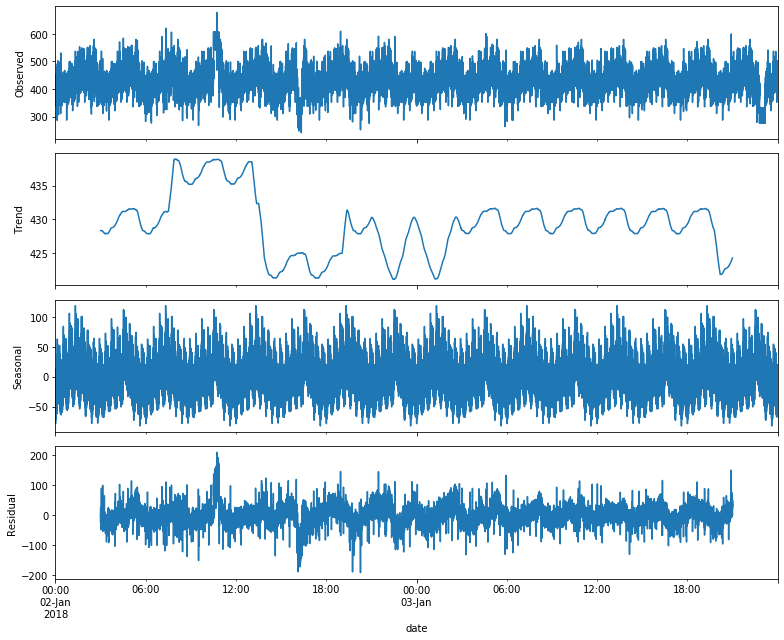

In [5]:
rcParams['figure.figsize'] = 11,9
decomposed_network = sm.tsa.seasonal_decompose(network, freq=21600)
figure = decomposed_network.plot()
plt.show()

,target
count,172799.000000
mean,0.000370
std,25.784710
min,-192.765426
25%,-17.000000
50%,0.000000
75%,17.000000
max,233.624171


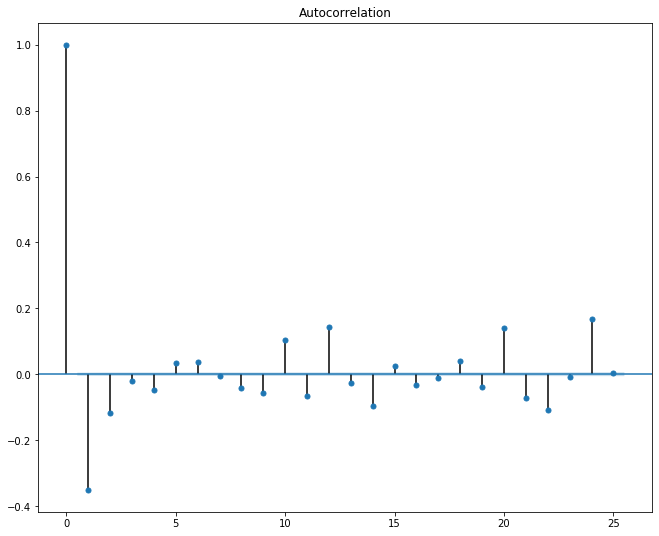

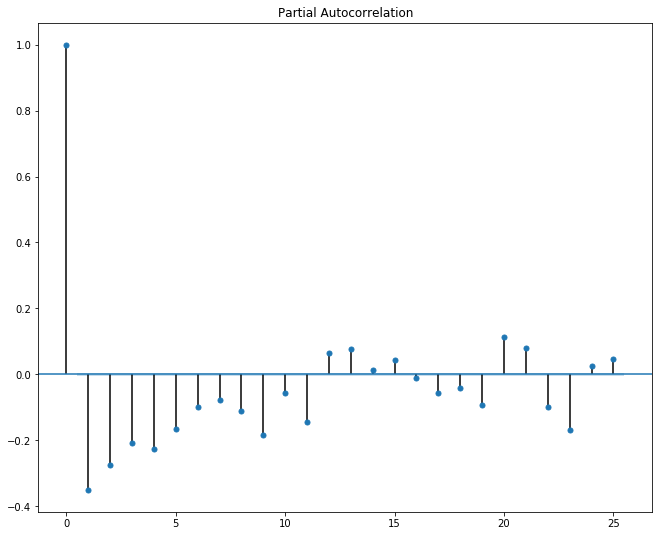

In [17]:
netdiff = network.diff()[1:]



plot_acf(netdiff, lags=25)
plot_pacf(netdiff, lags=25)

netdiff.describe()

C:\Users\HakkyuKim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)
C:\Users\HakkyuKim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D.target   No. Observations:               172799
Model:                 ARIMA(0, 1, 2)   Log Likelihood             -773858.071
Method:                       css-mle   S.D. of innovations             21.315
Date:                Thu, 05 Sep 2019   AIC                        1547724.142
Time:                        19:59:16   BIC                        1547764.381
Sample:                    01-02-2018   HQIC                       1547736.061
                         - 01-03-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0002      0.007      0.032      0.975      -0.013       0.014
ma.L1.D.target    -0.6539      0.002   -280.756      0.000      -0.658      -0.649
ma.L2.D.target    -0.2102      0.002

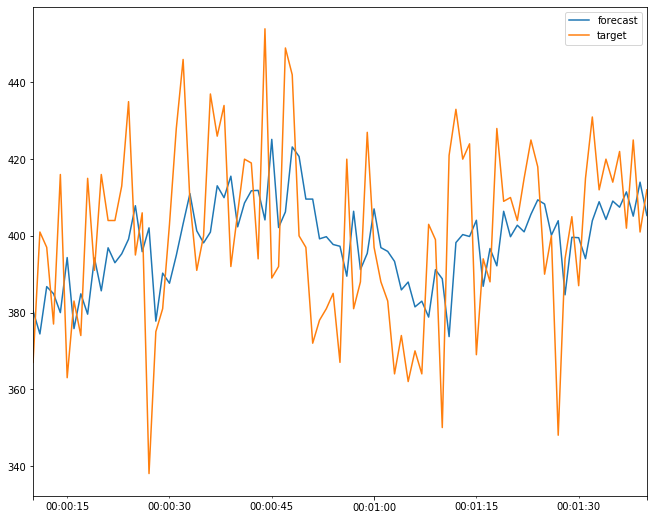

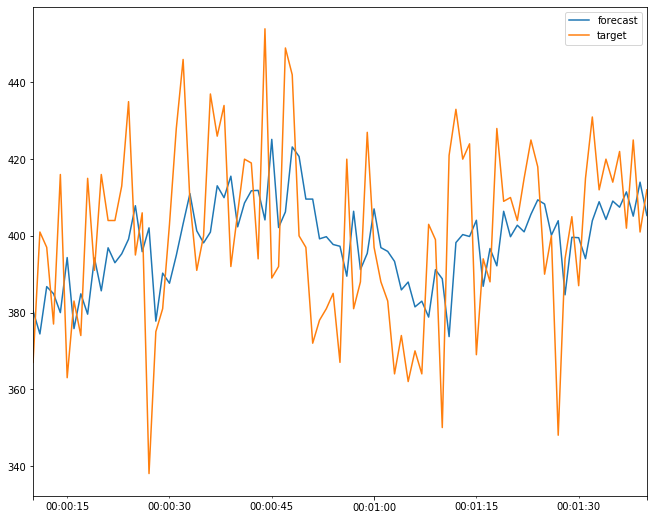

In [14]:
arima = ARIMA(network, order=(0, 1, 2))
result = arima.fit()
print(result.summary())

result.plot_predict(start = 10, end=100)

In [28]:
idx = network.index

tmp = network.shift(1)
tmp2 = network.shift(2)
tmp3 = network.shift(3)

network_prev = network.copy()
network_prev['prev1'] = tmp['target']
network_prev['prev2'] = tmp2['target']
network_prev['prev3'] = tmp3['target']

network_prev = network_prev[4:]
network_prev.head()

,target,prev1,prev2,prev3
date,,,,
2018-01-02 00:00:04,361.0,341.0,388.0,397.0
2018-01-02 00:00:05,359.0,361.0,341.0,388.0
2018-01-02 00:00:06,369.0,359.0,361.0,341.0
2018-01-02 00:00:07,387.0,369.0,359.0,361.0
2018-01-02 00:00:08,415.0,387.0,369.0,359.0


In [47]:
def partial_train(mtr, X_test, y_test, X_prev, y_prev):
    mtr.partial_fit(X_prev, y_prev)
    X_prev = X_test
    y_prev = y_test
    
    y_pred, y_std = mtr.predict(X_test, return_std=True)
    
    print('pred : %f, std: %f, y: %f'%(y_pred, y_std, y_test))

    


In [ ]:
X = network_prev[['prev1', 'prev2', 'prev3']]
y = network_prev['target']

X_train = X[:10000]
y_train = y[:10000]

X_test = X[10000:10001]
y_test = y[10000:10001]


mtr = MondrianForestRegressor(random_state=1, n_estimators=100, bootstrap=True)
mtr.partial_fit(X_train, y_train)
y_pred, y_std = mtr.predict(X_test, return_std=True)

for next in range(10001, 172701):
    X_prev = X_test
    y_prev = y_test
    X_test = X[next:next+1]
    y_test = y[next:next+1]

    partial_train(mtr, X_test, y_test, X_prev, y_prev)

